## Disease Prediction from Medical Data
Building a model that uses Machine Learning Classification Algorithms to Predict the Likelihood of a Disease.

__Importing libraries and modules__

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

__Loading dataset and Processing__

In [4]:
# Load the dataset
file_path = 'Cardio_Model_Training_Set.csv'
data = pd.read_csv(file_path)

# Data preprocessing
# Drop rows with missing values (if any)
data.dropna(inplace=True)

# Display basic information about the dataset
print("Basic Information about the Dataset:")
print(data.info())

# Display the first few rows of the dataset
print("\nFirst few rows of the dataset:")
print(data.head())

# Descriptive statistics for numerical variables
print("\nDescriptive Statistics for Numerical Features:")
print(data.describe())

Basic Information about the Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB
None

First few rows of the dataset:
   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80      

__Visualization of attributes__

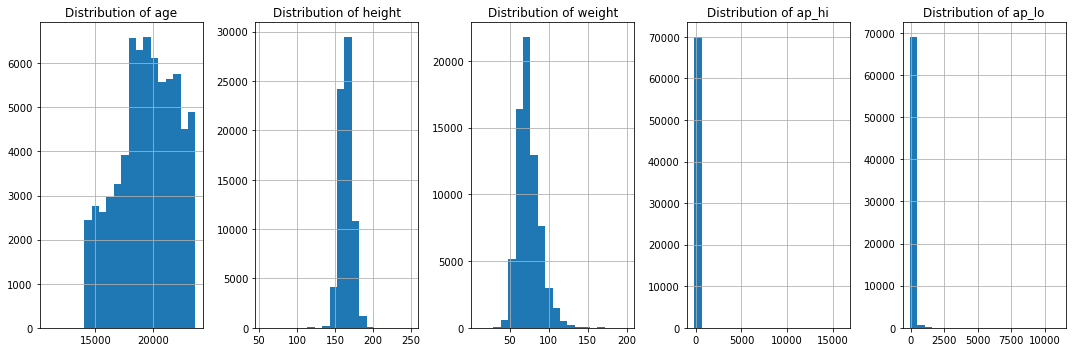

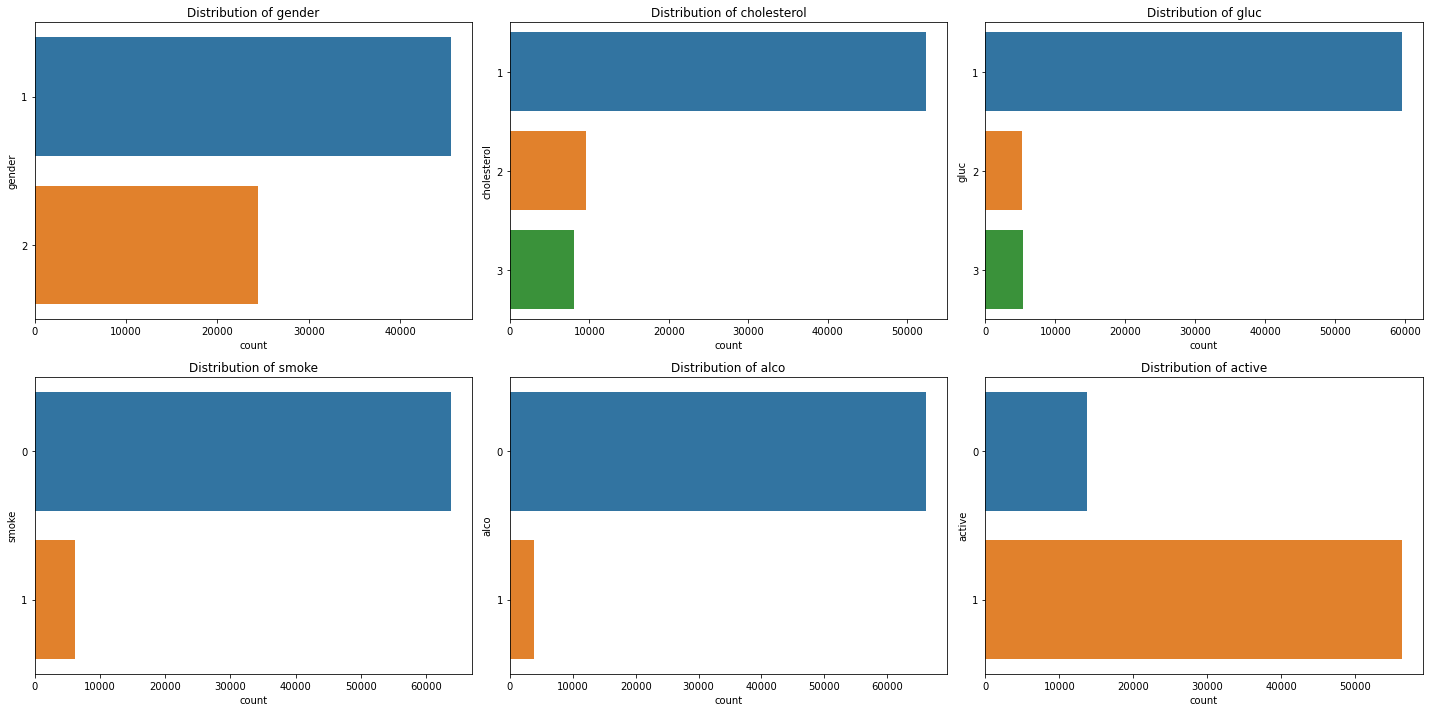

In [6]:
# Plotting histograms for the numerical variables
numerical_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 5, i)
    data[feature].hist(bins=20)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

#Visualizing the distribution of categorical variables
categorical_features = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
plt.figure(figsize=(20, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(y=feature, data=data)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

__Visualizing the relationship between different variables and disease occurrence__

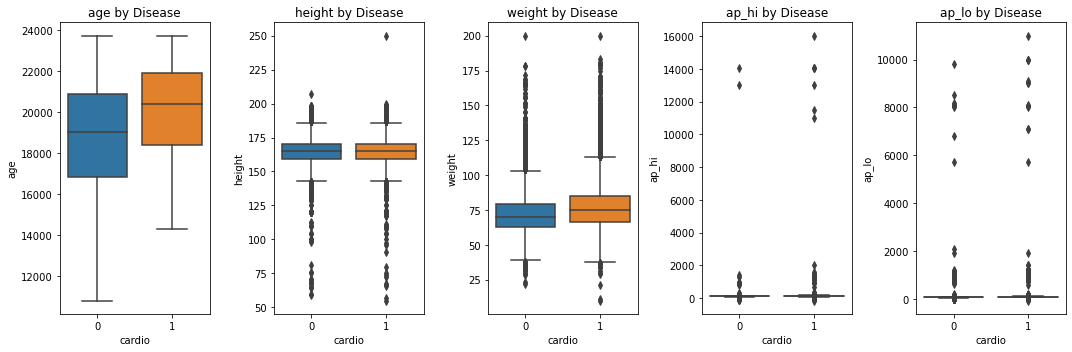

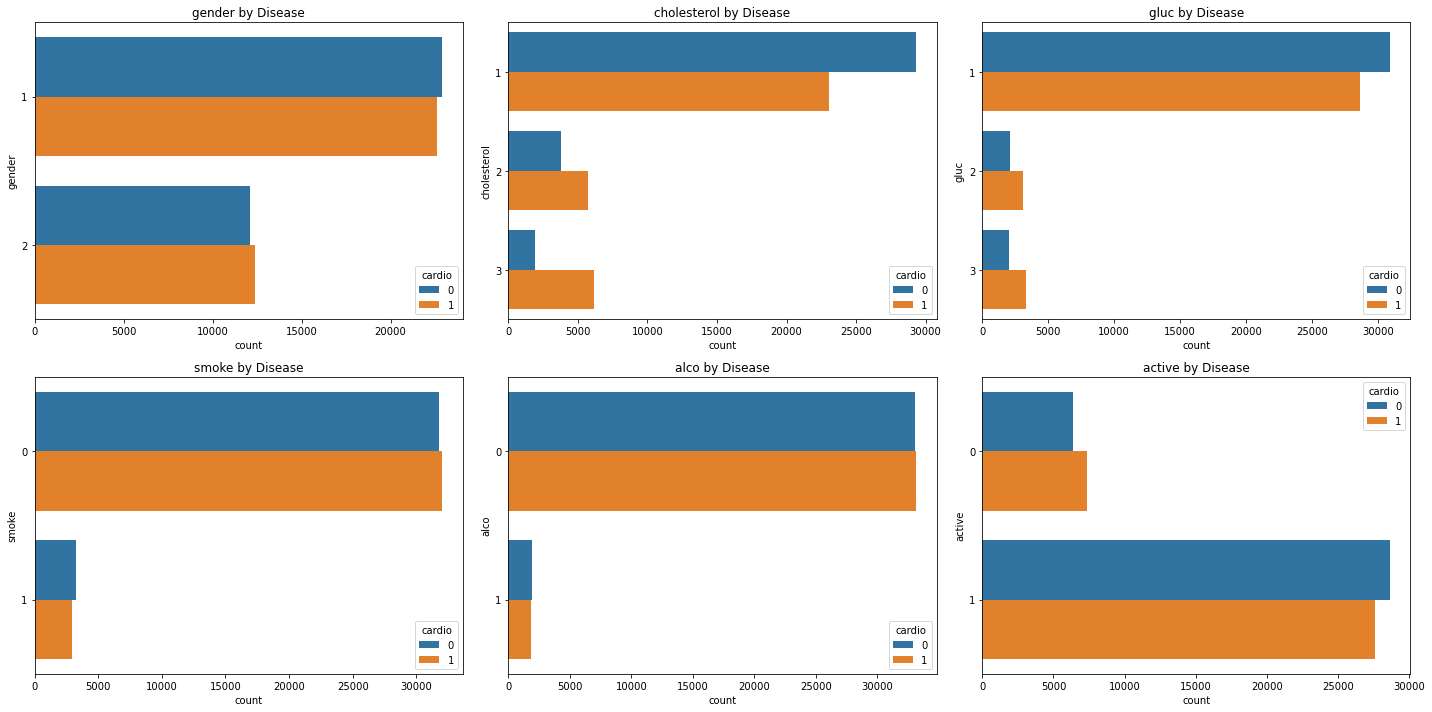

In [7]:
# For numerical features
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 5, i)
    sns.boxplot(x='cardio', y=feature, data=data)
    plt.title(f'{feature} by Disease')
plt.tight_layout()
plt.show()

# For categorical features
plt.figure(figsize=(20, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(y=feature, hue='cardio', data=data)
    plt.title(f'{feature} by Disease')
plt.tight_layout()
plt.show()

__Encoding__

In [8]:
# Features and target variable
X = data.drop(['cardio', 'id'], axis=1)
y = data['cardio']

# Encoding categorical variables using OneHotEncoder
categorical_features = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
numerical_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

# Preprocessing pipelines for both numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Handling class imbalance using SMOTE
smote = SMOTE(random_state=42)

# Split the dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



__Model Building__

In [9]:
# Models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Create and train models
for name, model in models.items():
    pipeline = ImbPipeline(steps=[('preprocessor', preprocessor),
                                  ('smote', smote),
                                  ('classifier', model)])
    pipeline.fit(X_train, y_train)
    
    # Evaluate model performance
    train_accuracy = pipeline.score(X_train, y_train)
    test_accuracy = pipeline.score(X_test, y_test)
    y_test_pred = pipeline.predict(X_test)
    
    print(f'\n{name} - Training Accuracy: {train_accuracy:.2f}')
    print(f'{name} - Test Accuracy: {test_accuracy:.2f}')
    print(f'{name} - Classification Report for Test Data:')
    print(classification_report(y_test, y_test_pred))
    print(f'{name} - Confusion Matrix for Test Data:')
    print(confusion_matrix(y_test, y_test_pred))
    print(f'{name} - ROC-AUC Score: {roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]):.2f}')

# Create an ensemble model using Voting Classifier
ensemble_model = VotingClassifier(
    estimators=[
        ('logreg', LogisticRegression()),
        ('rf', RandomForestClassifier(random_state=42)),
        ('gb', GradientBoostingClassifier(random_state=42))
    ],
    voting='soft'
)

# Train the ensemble model
ensemble_pipeline = ImbPipeline(steps=[('preprocessor', preprocessor),
                                       ('smote', smote),
                                       ('ensemble', ensemble_model)])
ensemble_pipeline.fit(X_train, y_train)





Logistic Regression - Training Accuracy: 0.72
Logistic Regression - Test Accuracy: 0.71
Logistic Regression - Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.70      0.75      0.72      7004
           1       0.73      0.67      0.70      6996

    accuracy                           0.71     14000
   macro avg       0.71      0.71      0.71     14000
weighted avg       0.71      0.71      0.71     14000

Logistic Regression - Confusion Matrix for Test Data:
[[5270 1734]
 [2279 4717]]
Logistic Regression - ROC-AUC Score: 0.78

Random Forest - Training Accuracy: 1.00
Random Forest - Test Accuracy: 0.71
Random Forest - Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.71      0.72      0.72      7004
           1       0.72      0.70      0.71      6996

    accuracy                           0.71     14000
   macro avg       0.71      0.71      0.71     14000


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'height', 'weight',
                                                   'ap_hi', 'ap_lo']),
                                                 ('cat', OneHotEncoder(),
                                                  ['gender', 'cholesterol',
                                                   'gluc', 'smoke', 'alco',
                                                   'active'])])),
                ('smote', SMOTE(random_state=42)),
                ('ensemble',
                 VotingClassifier(estimators=[('logreg', LogisticRegression()),
                                              ('rf',
                                               RandomForestClassifier(random_state=42)),
                                              ('gb',
                                               GradientBoostingClassifier(random_state=42))],
  

__Model Evaluation__

In [10]:
# Evaluate the ensemble model
ensemble_train_accuracy = ensemble_pipeline.score(X_train, y_train)
ensemble_test_accuracy = ensemble_pipeline.score(X_test, y_test)
ensemble_y_test_pred = ensemble_pipeline.predict(X_test)

print(f'\nEnsemble Model - Training Accuracy: {ensemble_train_accuracy:.2f}')
print(f'Ensemble Model - Test Accuracy: {ensemble_test_accuracy:.2f}')
print('Ensemble Model - Classification Report for Test Data:')
print(classification_report(y_test, ensemble_y_test_pred))
print('Ensemble Model - Confusion Matrix for Test Data:')
print(confusion_matrix(y_test, ensemble_y_test_pred))
print(f'Ensemble Model - ROC-AUC Score: {roc_auc_score(y_test, ensemble_pipeline.predict_proba(X_test)[:, 1]):.2f}')



Ensemble Model - Training Accuracy: 0.86
Ensemble Model - Test Accuracy: 0.73
Ensemble Model - Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      7004
           1       0.74      0.70      0.72      6996

    accuracy                           0.73     14000
   macro avg       0.73      0.73      0.73     14000
weighted avg       0.73      0.73      0.73     14000

Ensemble Model - Confusion Matrix for Test Data:
[[5284 1720]
 [2114 4882]]
Ensemble Model - ROC-AUC Score: 0.79


__Prediction__

In [11]:
# Predicting using the ensemble model (for demonstration)
sample_data = X_test.iloc[0:5]  # Just taking the first 5 samples for prediction
predictions = ensemble_pipeline.predict(sample_data)
print("\nPredictions for Sample Data:")
print(predictions)



Predictions for Sample Data:
[0 1 0 0 0]
